In [183]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

In [200]:
def ROC(original_dataset, fetched_pages):
    merged_data = pd.merge(original_dataset, fetched_pages, on="url", how="inner")
    merged_data['relevance'] = merged_data['relevance'].fillna(0)
    y_true = merged_data['relevance']
    y_scores = merged_data['score']
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    return(fpr, tpr, thresholds, roc_auc_score(y_true, y_scores))

def get_optimal_threshold(original_dataset, fetched_pages):
    fpr, tpr, thresholds, roc_auc = ROC(original_dataset, fetched_pages)
    distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)
    closest_index = np.argmin(distances)
    closest_fpr, closest_tpr, closest_threshold = fpr[closest_index], tpr[closest_index], thresholds[closest_index]
    return(closest_threshold)

def plot_ROC(original_dataset, fetched_pages) : 
    fpr, tpr, thresholds, roc_auc = ROC(original_dataset, fetched_pages)
    
    # Tracer la courbe ROC
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='blue')
    plt.plot([0, 1], [0, 1], 'r--', label="Random Guessing")  # Diagonale pour référence

    # Annoter certains points avec les seuils
    for i in range(0, len(thresholds), max(1, len(thresholds)//10)):  # Échantillonner 10 points environ
        plt.annotate(f"{thresholds[i]:.3f}", (fpr[i], tpr[i]), 
                     textcoords="offset points", xytext=(-10, 10), ha='center', fontsize=9, color='green')

    # Labels et légende
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve with Thresholds")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

In [286]:
def get_topk_threshold(fetched_pages, top_k):
    sorted_pages = fetched_pages.sort_values(by='score', ascending=False)
    if top_k > len(sorted_pages):
        topk_score = sorted_pages.iloc[-1]['score']
    else : 
        topk_score = sorted_pages.iloc[top_k - 1]['score']
    
    return(topk_score)

In [299]:
def keep_above_threshold(thresholds,fetched_pages):
    kept = fetched_pages[fetched_pages['score'] >= thresholds]
    return(kept)

In [257]:
def get_new_papers(labelled_data, fetched_pages) : 
    left_join = pd.merge(
        fetched_pages,
        labelled_data,
        on="url",
        how="left",
        suffixes=("", "_labelled"), 
        indicator=True,
    )
    columns_to_keep = [col for col in left_join.columns if not col.endswith("_labelled")]
    left_join = left_join[columns_to_keep]
    only_in_fetched = left_join[left_join["_merge"] == "left_only"].drop(columns=["_merge"])
    return(only_in_fetched)

def get_already_labelled_papers(original_dataset, fetched_pages):
    # Effectuer une jointure gauche entre 'fetched_pages' et 'original_dataset' basé sur 'url'
    left_join = pd.merge(
        fetched_pages,
        original_dataset,
        on="url",
        how="left",
        suffixes=("", "_labelled"),
        indicator=True,
    )
    
    # Conserver les colonnes du premier dataframe, en excluant les colonnes qui sont dans le second
    columns_to_keep = [col for col in left_join.columns if not col.endswith("_labelled")]
    left_join = left_join[columns_to_keep]
    
    # Extraire les lignes qui existent dans les deux dataframes (celles déjà étiquetées)
    already_labelled = left_join[left_join["_merge"] == "both"].drop(columns=["_merge"])
    already_labelled.drop(columns=["relevance"], inplace=True)
    
    return already_labelled


In [253]:
def recall_precision(fetched_pages, labelled_dataset) : 
    labelled_data_relevants = labelled_dataset[labelled_dataset['relevance']==1]

    merged_data = pd.merge(labelled_dataset, fetched_pages, on="url", how="inner")
    merged_data['relevance'] = merged_data['relevance'].fillna(0)
    relevants = merged_data[merged_data['relevance']==1]

    recall = len(relevants) / len(labelled_data_relevants) if len(labelled_data_relevants) > 0 else 0
    precision = len(relevants) / len(merged_data) if len(merged_data) > 0 else 0

    return(recall, precision)

In [281]:
def remove_duplicates(lst):
    seen = set()
    return [x for x in lst if not (x in seen or seen.add(x))]

def query_count(session_infos, fetched_pages, labelled_dataset=None):
    queries_count = []

    # Suppression des doublons de requêtes
    queries = remove_duplicates(list(session_infos['all_queries'])[0].split(';'))
    
    for query in queries:
        pages_for_query = fetched_pages[fetched_pages['get_with_query'] == query]

        # Si un dataset étiqueté est fourni, on filtre les pages pertinentes
        if labelled_dataset is not None:
            merged_data = pd.merge(labelled_dataset, pages_for_query, on="url", how="inner")
            merged_data['relevance'] = merged_data['relevance'].fillna(0)
            pages_for_query = merged_data[merged_data['relevance'] == 1]
            title = "Number of Relevant Pages Found per Query"
            ylabel = 'Number of Relevant Pages Found'
        else:
            title = 'Number of Pages Found per Query'
            ylabel = 'Number of Pages Found'

        num_pages_for_query = len(pages_for_query)
        queries_count.append(num_pages_for_query)

    # Indices pour les abscisses
    index = [i for i in range(len(queries))]
    
    # Tracé de l'histogramme
    plt.figure(figsize=(10, 6))
    bars = plt.bar(index, queries_count, edgecolor='black')

    # Ajouter le nombre au-dessus de chaque barre
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom', fontsize=10)

    plt.xlabel('Query Number')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [88]:
# original_dataset = pd.read_csv("/Users/apollineguerineau/Documents/ENSAI/3A/Greece/internship/eval/RAG_code_generation/dataset_rag.csv", sep=';')
# labelled_new_papers_path = "/Users/apollineguerineau/Documents/ENSAI/3A/Greece/internship/eval/RAG_code_generation/crawlers/all_new_pages_to_label.csv"
# path_to_crawlers = "/Users/apollineguerineau/Documents/ENSAI/3A/Greece/internship/eval/RAG_code_generation/crawlers/"
# crawlers = [f for f in os.listdir(path_to_crawlers) if os.path.isdir(os.path.join(path_to_crawlers, f))]
# print(len(crawlers))

7


In [277]:
original_dataset = pd.read_csv("/Users/apollineguerineau/Documents/ENSAI/3A/Greece/internship/eval/ML_MOF_Diffusion/dataset_ML_MOF_Diffusion.csv", sep=";")
labelled_new_papers_path = "/Users/apollineguerineau/Documents/ENSAI/3A/Greece/internship/eval/ML_MOF_Diffusion/crawlers_v1/new_papers_to_label.csv"
path_to_crawlers = "/Users/apollineguerineau/Documents/ENSAI/3A/Greece/internship/eval/ML_MOF_Diffusion/crawlers_v1/"
crawlers = [f for f in os.listdir(path_to_crawlers) if os.path.isdir(os.path.join(path_to_crawlers, f))]
print(len(crawlers))

4


In [278]:
all_new_papers = []

for crawler in crawlers : 
    path = path_to_crawlers+crawler+"/fetched_pages.csv"
    if os.path.exists(path):
        path_fetched_pages = os.path.join(path_to_crawlers, crawler+"/fetched_pages.csv")
        fetched_pages = pd.read_csv(path_fetched_pages)
        only_in_fetched = get_new_papers(original_dataset, fetched_pages)
        optimal_threshold = get_optimal_threshold(original_dataset, fetched_pages)
        kept_papers_not_in_original = keep_above_threshold(optimal_threshold,only_in_fetched)
        all_new_papers.append(kept_papers_not_in_original)

new_papers = pd.concat(all_new_papers, ignore_index=True)
if os.path.exists(labelled_new_papers_path):
    labelled_new_papers = pd.read_csv(labelled_new_papers_path)  
    combined_new_papers = pd.concat([new_papers,labelled_new_papers], ignore_index=True)
else : 
    combined_new_papers = new_papers

combined_new_papers["has_relevance"] = combined_new_papers["relevance"].notna()
combined_new_papers = combined_new_papers.sort_values(by="has_relevance", ascending=False)
unique_new_papers = combined_new_papers.drop_duplicates(subset=["url"])
columns_to_keep = ["url", "title", "description", "relevance"]
filtered_new_papers = unique_new_papers.loc[:, columns_to_keep]
filtered_new_papers.to_csv(os.path.join(path_to_crawlers, "new_papers_to_label.csv"), index=False)

missing_relevance = filtered_new_papers[filtered_new_papers['relevance'].isna()]
print(f'{len(missing_relevance)} papers to label')


1 papers to label


seed_query_based_hyde_sim_cos_thr_0.882_pages_50
nb papers fetched in total : 27624


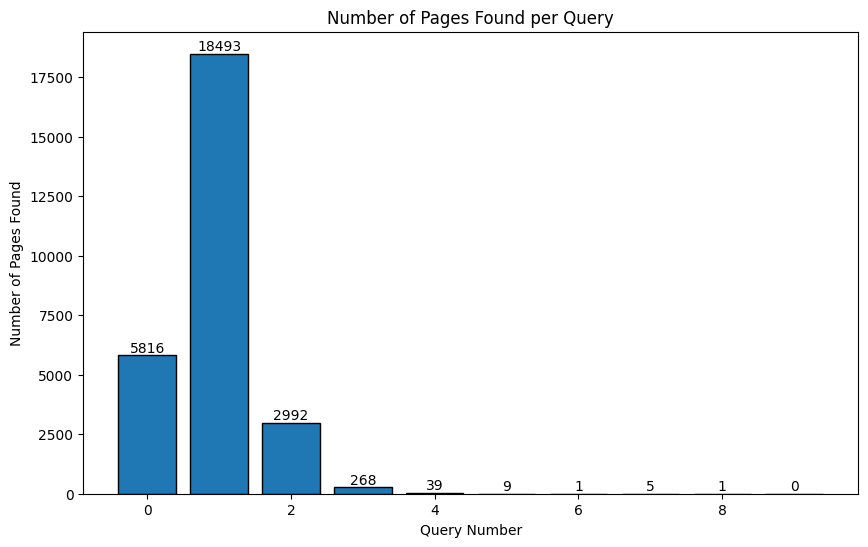

nb papers already labelled in original dataset : 6071
nb papers not labelled in original dataset : 21553
optimal threshold : 0.9112717067026084
nb papers kept in total with threshold 0.9112717067026084: 199
nb papers kept present in original dataset with threshold 0.9112717067026084: 197
nb papers kept not present in original dataset with threshold 0.9112717067026084: 2
recall in original dataset : 1.0 - precision in original dataset : 0.000823587547356284
recall total : 1.0 - precision total : 0.0008223684210526315


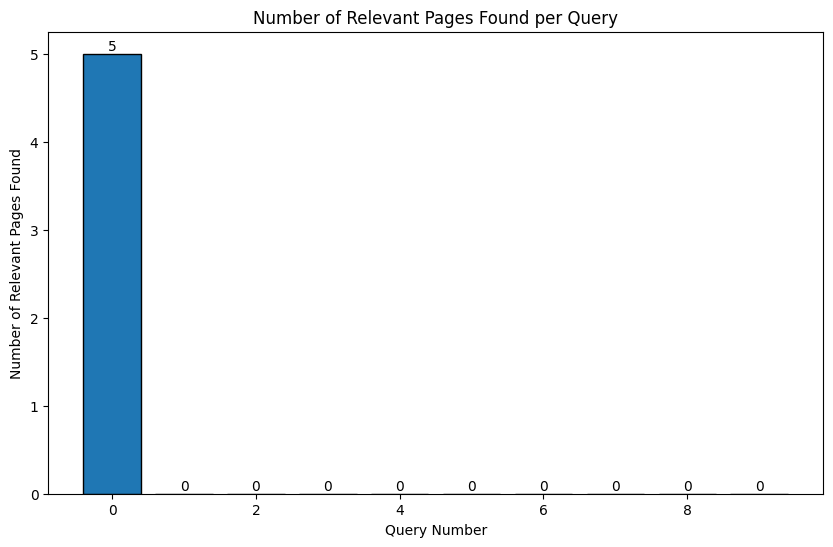

--------------------------------------------------------
best_paper_based_sim_cos_thr_0.802_pages_50
nb papers fetched in total : 27648


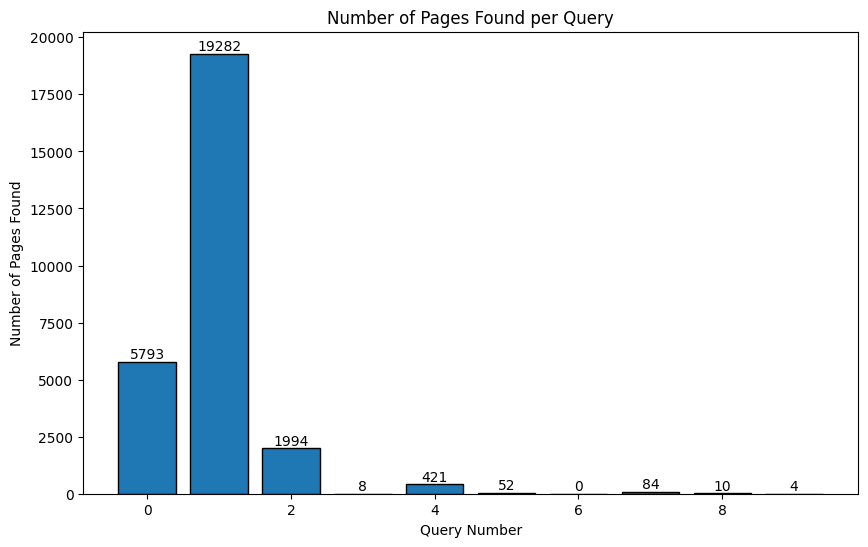

nb papers already labelled in original dataset : 6068
nb papers not labelled in original dataset : 21580
optimal threshold : 0.8507010391484567
nb papers kept in total with threshold 0.8507010391484567: 371
nb papers kept present in original dataset with threshold 0.8507010391484567: 361
nb papers kept not present in original dataset with threshold 0.8507010391484567: 10
recall in original dataset : 1.0 - precision in original dataset : 0.0008239947264337508
recall total : 1.0 - precision total : 0.0008226390259953932


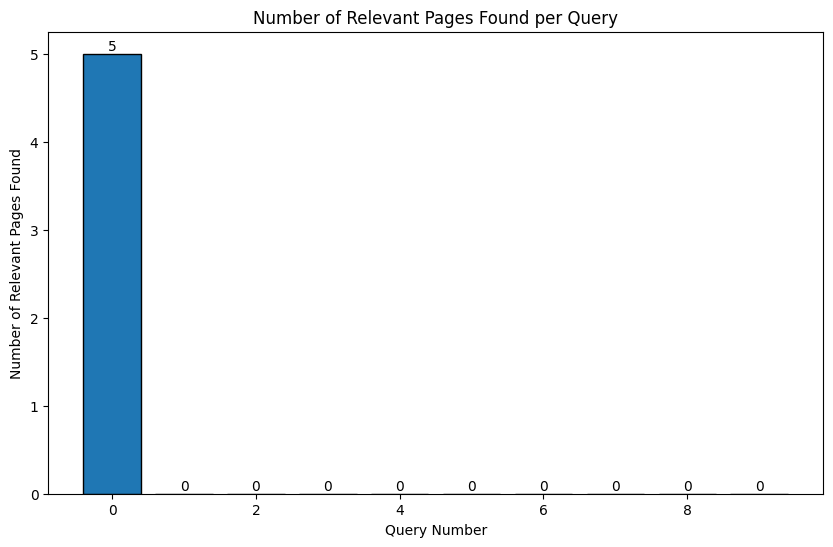

--------------------------------------------------------
seed_query_based_sim_cos_thr_0.802_pages_50
nb papers fetched in total : 27624


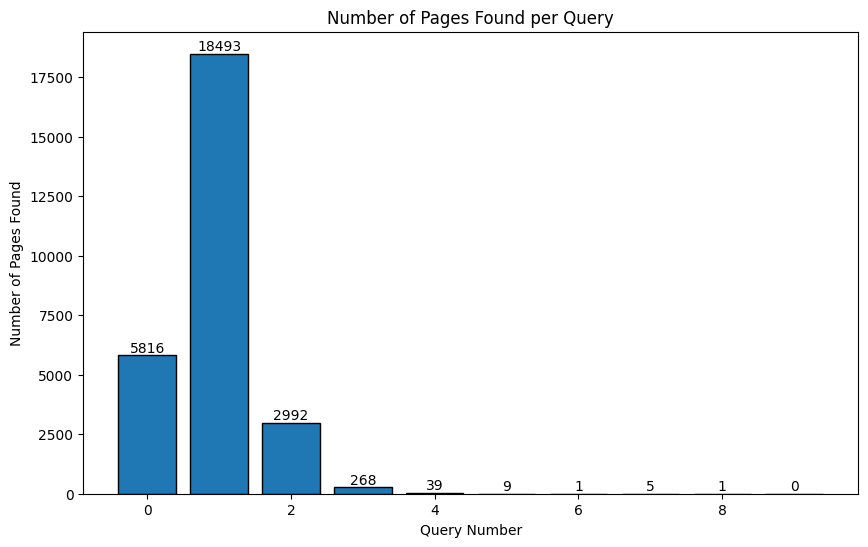

nb papers already labelled in original dataset : 6071
nb papers not labelled in original dataset : 21553
optimal threshold : 0.8507010391484567
nb papers kept in total with threshold 0.8507010391484567: 370
nb papers kept present in original dataset with threshold 0.8507010391484567: 361
nb papers kept not present in original dataset with threshold 0.8507010391484567: 9
recall in original dataset : 1.0 - precision in original dataset : 0.000823587547356284
recall total : 1.0 - precision total : 0.0008223684210526315


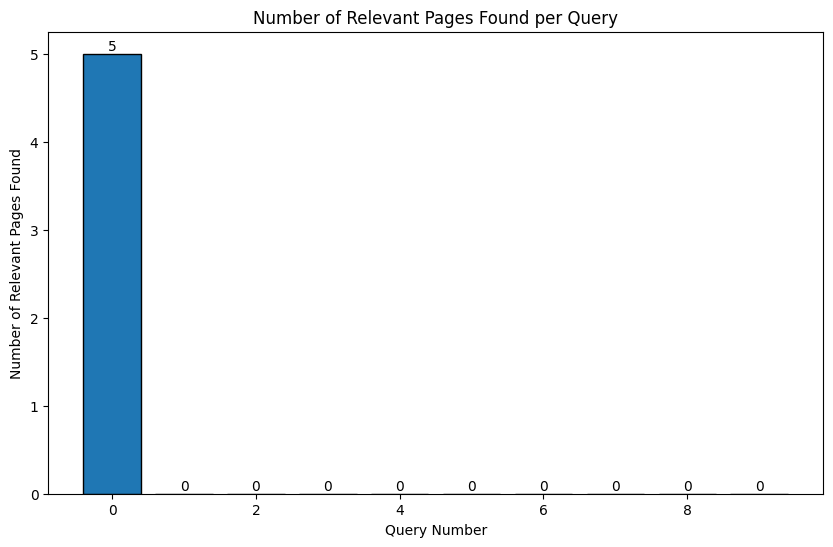

--------------------------------------------------------


In [282]:
for crawler in crawlers : 
    path = os.path.join(path_to_crawlers, crawler+"/session_infos.csv")
    if os.path.exists(path):
        path_session_infos = os.path.join(path_to_crawlers, crawler+"/session_infos.csv")
        session_infos = pd.read_csv(path_session_infos)
        path_fetched_pages = os.path.join(path_to_crawlers, crawler+"/fetched_pages.csv")
        fetched_pages = pd.read_csv(path_fetched_pages)

        already_labelled_papers = get_already_labelled_papers(original_dataset, fetched_pages)
        only_in_fetched = get_new_papers(original_dataset, fetched_pages)

        optimal_threshold = get_optimal_threshold(original_dataset, fetched_pages)
        kept_papers_total = keep_above_threshold(optimal_threshold,fetched_pages)
        kept_papers_in_original = keep_above_threshold(optimal_threshold,already_labelled_papers)
        kept_papers_not_in_original = keep_above_threshold(optimal_threshold,only_in_fetched)
        
        recall_original, precision_original = recall_precision(fetched_pages, original_dataset)
        if os.path.exists(labelled_new_papers_path):
            labelled_new_papers = pd.read_csv(labelled_new_papers_path)  
            labelled_new_papers['relevance'] = labelled_new_papers['relevance'].fillna(0)
            labelled_total = pd.concat([original_dataset,labelled_new_papers], ignore_index=True)
            labelled_total = labelled_total.drop_duplicates(subset=["url"])
            recall_total, precision_total = recall_precision(fetched_pages, labelled_total)


        print(crawler)
        print(f'nb papers fetched in total : {len(fetched_pages)}')
        query_count(session_infos, fetched_pages)
        print(f'nb papers already labelled in original dataset : {len(already_labelled_papers)}')
        print(f'nb papers not labelled in original dataset : {len(only_in_fetched)}')
        print(f'optimal threshold : {optimal_threshold}')
        print(f'nb papers kept in total with threshold {optimal_threshold}: {len(kept_papers_total)}')
        print(f'nb papers kept present in original dataset with threshold {optimal_threshold}: {len(kept_papers_in_original)}')
        print(f'nb papers kept not present in original dataset with threshold {optimal_threshold}: {len(kept_papers_not_in_original)}')
        print(f'recall in original dataset : {recall_original} - precision in original dataset : {precision_original}')
        if recall_total and precision_total : 
            print(f'recall total : {recall_total} - precision total : {precision_total}')
            query_count(session_infos, fetched_pages, labelled_dataset=labelled_total)
        print('--------------------------------------------------------')
        # plot_ROC(original_dataset, fetched_pages)


In [295]:
def print_threshold(threshold_dict, value):
    if threshold_dict['method'] == 'optimal' : 
        return(f'{value} (optimal)')

    if threshold_dict['method'] == 'top@k' : 
        return(f'{value} (top {threshold_dict["topk"]} papers)')

In [292]:
def results(crawler, threshold_dict='optimal', top_k=None):
    path = os.path.join(path_to_crawlers, crawler+"/session_infos.csv")
    if os.path.exists(path):
        path_session_infos = os.path.join(path_to_crawlers, crawler+"/session_infos.csv")
        session_infos = pd.read_csv(path_session_infos)
        path_fetched_pages = os.path.join(path_to_crawlers, crawler+"/fetched_pages.csv")
        fetched_pages = pd.read_csv(path_fetched_pages)

        already_labelled_papers = get_already_labelled_papers(original_dataset, fetched_pages)
        only_in_fetched = get_new_papers(original_dataset, fetched_pages)

        if threshold_dict['method'] == 'optimal' : 
            threshold = get_optimal_threshold(original_dataset, fetched_pages)
        
        if threshold_dict['method'] == 'top@k':
            threshold = get_topk_threshold(fetched_pages, threshold_dict['topk'])

        kept_papers_total = keep_above_threshold(threshold,fetched_pages)
        kept_papers_in_original = keep_above_threshold(threshold,already_labelled_papers)
        kept_papers_not_in_original = keep_above_threshold(threshold,only_in_fetched)
        
        # recall_original, precision_original = recall_precision(kept_papers_not_in_original, original_dataset)
        if os.path.exists(labelled_new_papers_path):
            labelled_new_papers = pd.read_csv(labelled_new_papers_path)  
            labelled_new_papers['relevance'] = labelled_new_papers['relevance'].fillna(0)
            labelled_total = pd.concat([original_dataset,labelled_new_papers], ignore_index=True)
            labelled_total = labelled_total.drop_duplicates(subset=["url"])
            # recall_total, precision_total = recall_precision(kept_papers_total, labelled_total)


        print(crawler)
        print(f'nb papers fetched in total : {len(fetched_pages)}')
        query_count(session_infos, fetched_pages)
        print(f'nb papers already labelled in original dataset : {len(already_labelled_papers)}')
        print(f'nb papers not labelled in original dataset : {len(only_in_fetched)}')
        print(f'optimal threshold : {print_threshold(threshold_dict,threshold)}')
        print(f'nb papers kept in total with threshold {print_threshold(threshold_dict,threshold)}: {len(kept_papers_total)}')
        print(f'nb papers kept present in original dataset with threshold {print_threshold(threshold_dict,threshold)}: {len(kept_papers_in_original)}')
        print(f'nb papers kept not present in original dataset with threshold {print_threshold(threshold_dict,threshold)}: {len(kept_papers_not_in_original)}')
        # print(f'recall {recall_original} and precision {precision_original} in original dataset with threshold {print_threshold(threshold_dict,threshold)}')
        if recall_total and precision_total : 
            # print(f'recall {recall_total} and precision {precision_total} in total with threshold {print_threshold(threshold_dict,threshold)}')
            query_count(session_infos, fetched_pages, labelled_dataset=labelled_total)
        print('--------------------------------------------------------')

seed_query_based_hyde_sim_cos_thr_0.882_pages_50
nb papers fetched in total : 27624


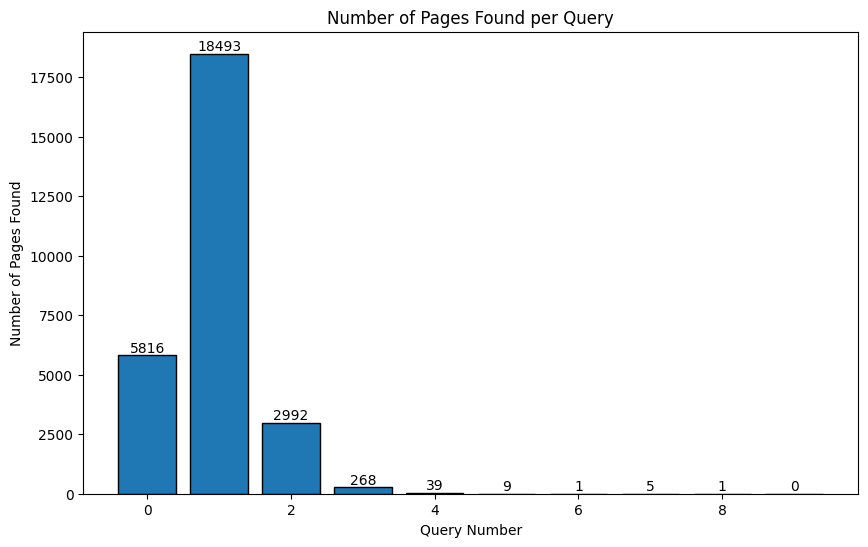

nb papers already labelled in original dataset : 6071
nb papers not labelled in original dataset : 21553
optimal threshold : 0.9179945469672848 (top 100 papers)
nb papers kept in total with threshold 0.9179945469672848 (top 100 papers): 100
nb papers kept present in original dataset with threshold 0.9179945469672848 (top 100 papers): 99
nb papers kept not present in original dataset with threshold 0.9179945469672848 (top 100 papers): 1


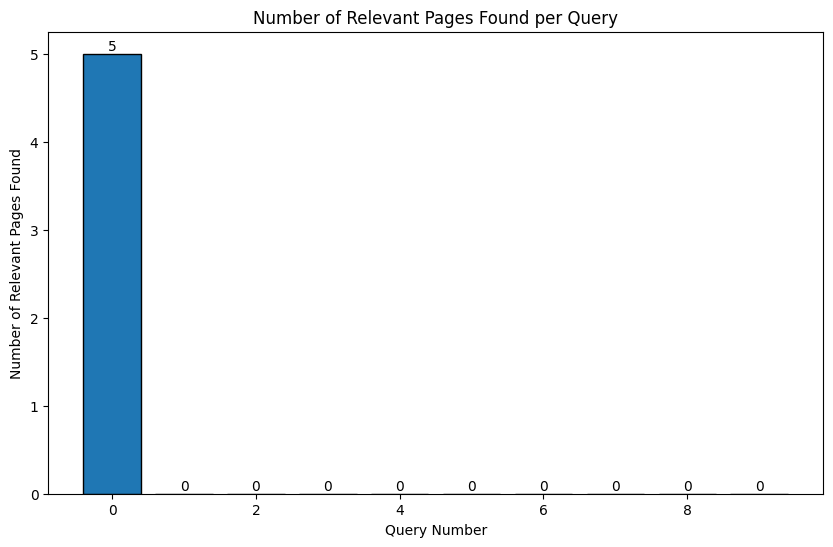

--------------------------------------------------------
best_paper_based_sim_cos_thr_0.802_pages_50
nb papers fetched in total : 27648


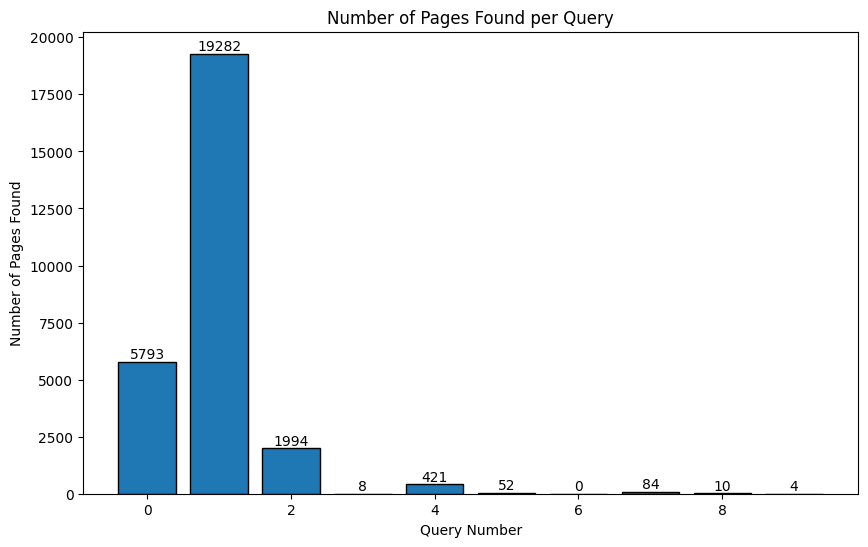

nb papers already labelled in original dataset : 6068
nb papers not labelled in original dataset : 21580
optimal threshold : 0.8612076445642164 (top 100 papers)
nb papers kept in total with threshold 0.8612076445642164 (top 100 papers): 100
nb papers kept present in original dataset with threshold 0.8612076445642164 (top 100 papers): 97
nb papers kept not present in original dataset with threshold 0.8612076445642164 (top 100 papers): 3


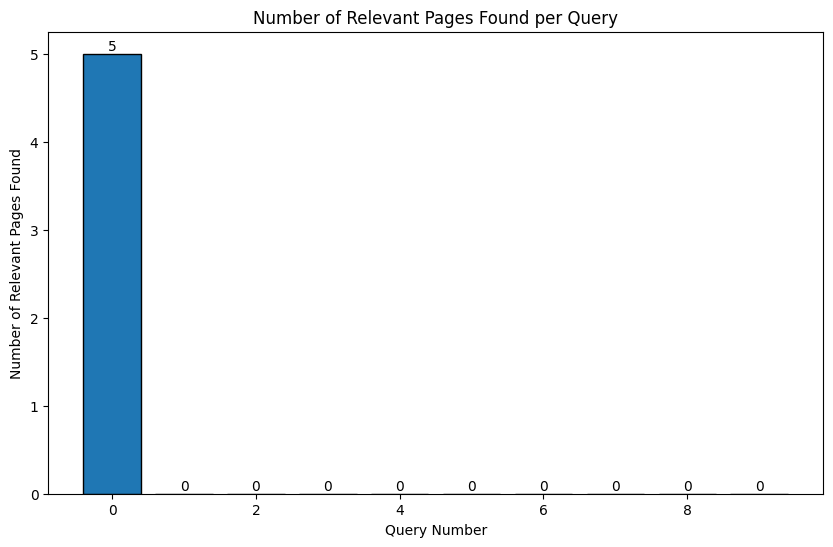

--------------------------------------------------------
seed_query_based_sim_cos_thr_0.802_pages_50
nb papers fetched in total : 27624


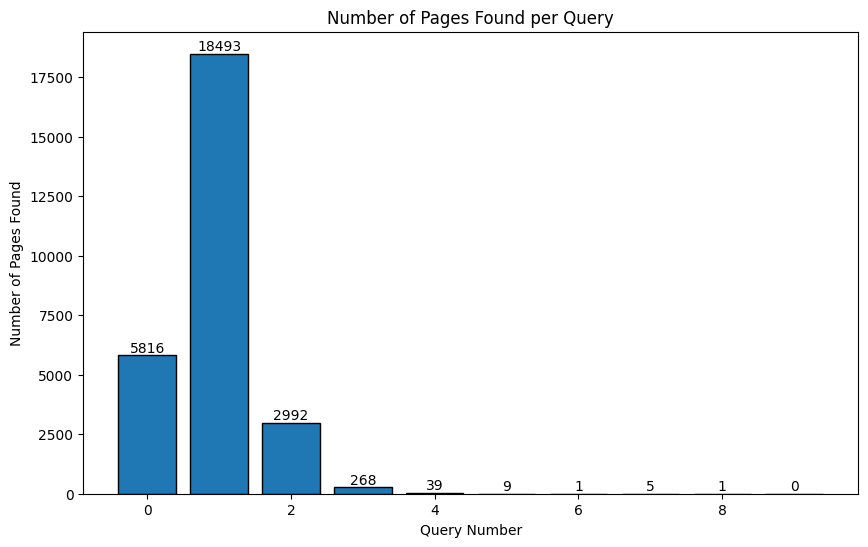

nb papers already labelled in original dataset : 6071
nb papers not labelled in original dataset : 21553
optimal threshold : 0.8611182991771889 (top 100 papers)
nb papers kept in total with threshold 0.8611182991771889 (top 100 papers): 100
nb papers kept present in original dataset with threshold 0.8611182991771889 (top 100 papers): 98
nb papers kept not present in original dataset with threshold 0.8611182991771889 (top 100 papers): 2


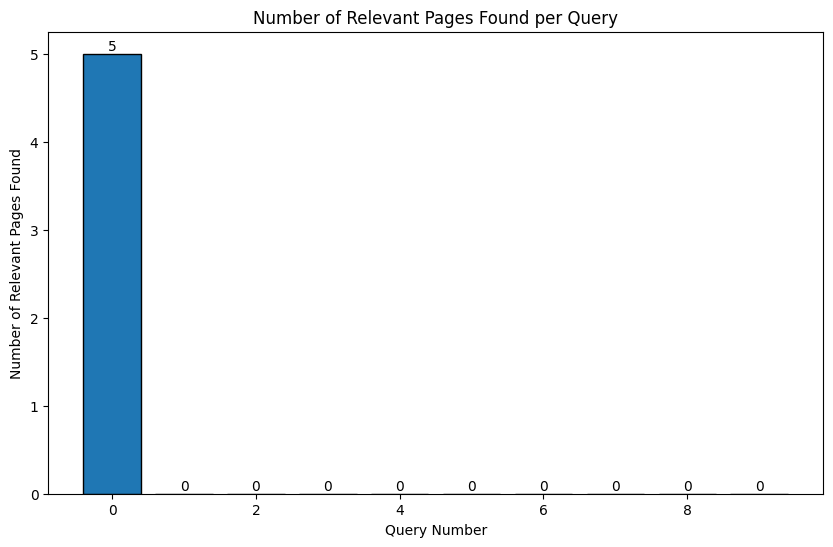

--------------------------------------------------------


In [300]:
for crawler in crawlers :
    # threshold_dict = {'method':'optimal', 'topk':None}
    threshold_dict = {'method':'top@k', 'topk':100}
    results(crawler, threshold_dict)